In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 15.7 MB/s 


In [3]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os
import matplotlib.image as mpimg
import matplotlib.image as img
from matplotlib.image import imread
import seaborn as sns
from PIL import Image
from PIL import ImageFont
import cv2
from time import time
from datetime import datetime
from statistics import mean

In [46]:
# Importar los paquetes de keras y tensorflow
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import (Dense, Dropout, Conv2D, Flatten, AveragePooling2D, BatchNormalization,
                          Activation, MaxPooling2D, ZeroPadding2D)
from keras.utils import np_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_recall_curve, recall_score, precision_score
from mlxtend.plotting import plot_confusion_matrix
from IPython.core.pylabtools import figsize
from keras.utils.metrics_utils import ConfusionMatrix
from tensorflow.keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.utils.vis_utils import plot_model
import visualkeras
from collections import defaultdict

In [20]:
direccion_entrenamiento = '/content/drive/MyDrive/Tarea 6/DATASET/TRAIN'
direccion_prueba = '/content/drive/MyDrive/Tarea 6/DATASET/TEST'

In [21]:
def conteo_datos(direccion_archivo):
    conteo_clase = {}
    conteo_total = 0
    if 'pred' in direccion_archivo:
        return len(os.listdir(os.path.join(direccion_archivo))), conteo_clase
    else:
        for nombre_clase in os.listdir(os.path.join(direccion_archivo)):
            conteo = len(os.listdir(os.path.join(direccion_archivo, nombre_clase)))
            conteo_clase[nombre_clase] = conteo
            conteo_total += conteo
    return conteo_total, conteo_clase

In [22]:
conteo_entrenamiento, conteo_clase_entrenamiento = conteo_datos(direccion_entrenamiento)
conteo_prueba, conteo_clase_prueba = conteo_datos(direccion_prueba)

print('Tamaño de datos de entrenamineto: ', conteo_entrenamiento, conteo_clase_entrenamiento)
print('Tamaño de datos de entrenamineto: ', conteo_prueba, conteo_clase_prueba)

Tamaño de datos de entrenamineto:  22564 {'O': 12565, 'R': 9999}
Tamaño de datos de entrenamineto:  2513 {'O': 1401, 'R': 1112}


In [23]:
# Guarda la dirección de la primera imagen de cada categría
etiquetas_imagenes = ['Organico', 'Reciclable']
carpeta = os.listdir(direccion_entrenamiento)

guardar_ima = []

for i in carpeta:
  aux = '/' + i
  aux2 = os.listdir(direccion_entrenamiento + aux)[0]
  aux3 = aux + '/'
  aux4 = aux3 + aux2
  aux5 = direccion_entrenamiento + aux4
  guardar_ima.append(aux5)

guardar_ima

['/content/drive/MyDrive/Tarea 6/DATASET/TRAIN/O/O_8505.jpg',
 '/content/drive/MyDrive/Tarea 6/DATASET/TRAIN/R/R_9755.jpg']

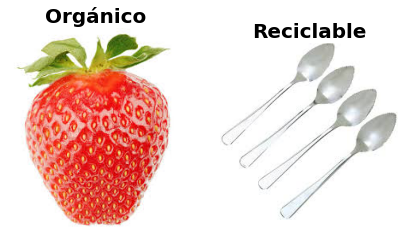

In [24]:
# Mostrar la primera imagen de cada categría
# Gráficar una imagen Orgánica y Reciclable
Organico = direccion_entrenamiento + '/O/O_1.jpg'
Organico2 = imread(Organico)
Reciclable = direccion_entrenamiento + '/R/R_9411.jpg'
Reciclable2 = imread(Reciclable)

Imagenes = [Organico2, Reciclable2]
Etiquetas_imagenes = ['Orgánico', 'Reciclable']

for i in range(2):
    plt.figure(1, figsize = (7, 5))
    plt.subplot(1, 2, i + 1)
    plt.title(Etiquetas_imagenes[i], fontweight = 'bold', fontsize = 20)
    plt.imshow(Imagenes[i])
    plt.axis('off')

plt.show()

In [51]:
Nuevas_imagenes_entrenamineto = ImageDataGenerator(rescale = 1/255, # Normaliza las imágenes
                                                   horizontal_flip = True, # Voltea aleatoriamente las imágenes horizontalmente
                                                   vertical_flip = True, # Voltea aleatoriamente las imágenes verticalmente
                                                   #rotation_range = 20, # Rotación aleatoria
                                                   #zoom_range = 0.1 # Zoom aleatorio
                                                   )

Nuevas_imagenes_validacion = ImageDataGenerator(rescale = 1/255, # Normaliza las imágenes
                                                validation_split = 0.4 # 40% de imágenes a validación
                                                )


Nuevas_imagenes_prueba = ImageDataGenerator(rescale = 1/255 # Normaliza las imágenes
                                            )

In [52]:
# Cambiando aleatoriamente las imágenes
tam_imagen = (225, 225)
batch_size = 16

Entrenamiento = Nuevas_imagenes_entrenamineto.flow_from_directory(direccion_entrenamiento, # Carpeta donde se encuentran las imágenes
                                                                  target_size = tam_imagen, # Reescalando el tamaño de las imágenes
                                                                  batch_size = batch_size, # Tamaño del batch size
                                                                  class_mode = 'binary', # Tipo de variable
                                                                  color_mode = 'rgb', # Canal de la imagen
                                                                  shuffle = True, # Mezclar las imágenes
                                                                  classes = ['O', 'R'] # Etiqueta de las clases
                                                                  )

Validacion = Nuevas_imagenes_validacion.flow_from_directory(direccion_entrenamiento, # Carpeta donde se encuentran las imágenes
                                                            target_size = tam_imagen, # Reescalando el tamaño de las imágenes
                                                            batch_size = batch_size, # Tamaño del batch size
                                                            class_mode = 'binary', # Tipo de variable
                                                            color_mode = 'rgb', # Canal de la imagen
                                                            shuffle = False, # Mezclar las imágenes
                                                            subset = 'validation', # Imágenes de validación
                                                            classes = ['O', 'R'] # Etiqueta de las clases
                                                            )

Prueba = Nuevas_imagenes_prueba.flow_from_directory(direccion_prueba, # Carpeta donde se encuentran las imágenes
                                                    target_size = tam_imagen, # Reescalando el tamaño de las imágenes
                                                    batch_size = batch_size, # Tamaño del batch size
                                                    class_mode = 'binary', # Tipo de variable
                                                    color_mode = 'rgb', # Canal de la imagen
                                                    shuffle = False, # Mezclar las imágenes
                                                    classes = ['O', 'R'] # Etiqueta de las clases
                                                    )

Found 22564 images belonging to 2 classes.
Found 9025 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [53]:
# Etiqueta de las clases
Entrenamiento.class_indices

{'O': 0, 'R': 1}

In [54]:
# Construcción del modelo
modelo = Sequential()
modelo.add(Conv2D(16, (11, 11), input_shape=(225, 225, 3),
        padding='same', kernel_regularizer = l2(0)))
modelo.add(BatchNormalization())
modelo.add(Activation('relu'))
modelo.add(MaxPooling2D(pool_size=(2, 2)))

# Capa 2
modelo.add(Conv2D(36, (5, 5), padding='same'))
modelo.add(BatchNormalization())
modelo.add(Activation('relu'))
modelo.add(MaxPooling2D(pool_size=(2, 2)))

# Capa 3
modelo.add(ZeroPadding2D((1, 1)))
modelo.add(Conv2D(64, (3, 3), padding='same'))
modelo.add(BatchNormalization())
modelo.add(Activation('relu'))
modelo.add(MaxPooling2D(pool_size=(2, 2)))

# Capa 4
modelo.add(ZeroPadding2D((1, 1)))
modelo.add(Conv2D(128, (3, 3), padding='same'))
modelo.add(BatchNormalization())
modelo.add(Activation('relu'))

# Capa 5
modelo.add(ZeroPadding2D((1, 1)))
modelo.add(Conv2D(128, (3, 3), padding='same'))
modelo.add(BatchNormalization())
modelo.add(Activation('relu'))
modelo.add(MaxPooling2D(pool_size=(2, 2)))

# Capa 6
modelo.add(Flatten())
modelo.add(Dense(256))
modelo.add(BatchNormalization())
modelo.add(Activation('relu'))
modelo.add(Dropout(0.5))

# Capa 7
modelo.add(Dense(512))
modelo.add(BatchNormalization())
modelo.add(Activation('relu'))
modelo.add(Dropout(0.5))

# Capa 8
modelo.add(Dense(1))
modelo.add(BatchNormalization())
modelo.add(Activation('sigmoid'))

In [55]:
# Métricas
metricas = [tf.keras.metrics.BinaryAccuracy(name = 'binary_accuracy'),
            tf.keras.metrics.Precision(name = 'precision'),
            tf.keras.metrics.Recall(name = 'recall'),
            tf.keras.metrics.AUC(name = 'auc')]

# Función de perdida y el optimizador
modelo.compile(loss = tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy'),
               optimizer = 'adam',
               metrics = metricas)

In [56]:
# Resumen del modelo
modelo.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 225, 225, 16)      5824      
                                                                 
 batch_normalization_17 (Bat  (None, 225, 225, 16)     64        
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 225, 225, 16)      0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 36)      14436     
                                                                 
 batch_normalization_18 (Bat  (None, 112, 112, 36)    

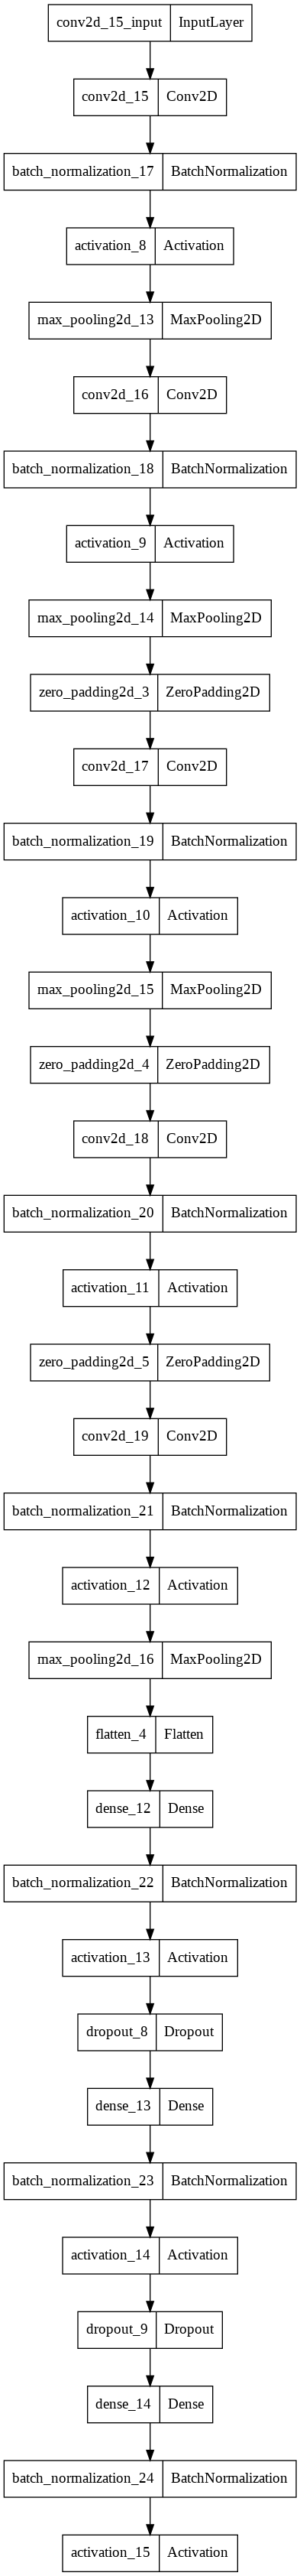

In [57]:
plot_model(modelo, to_file = '/content/drive/MyDrive/Tarea 6/modelo_1.png')

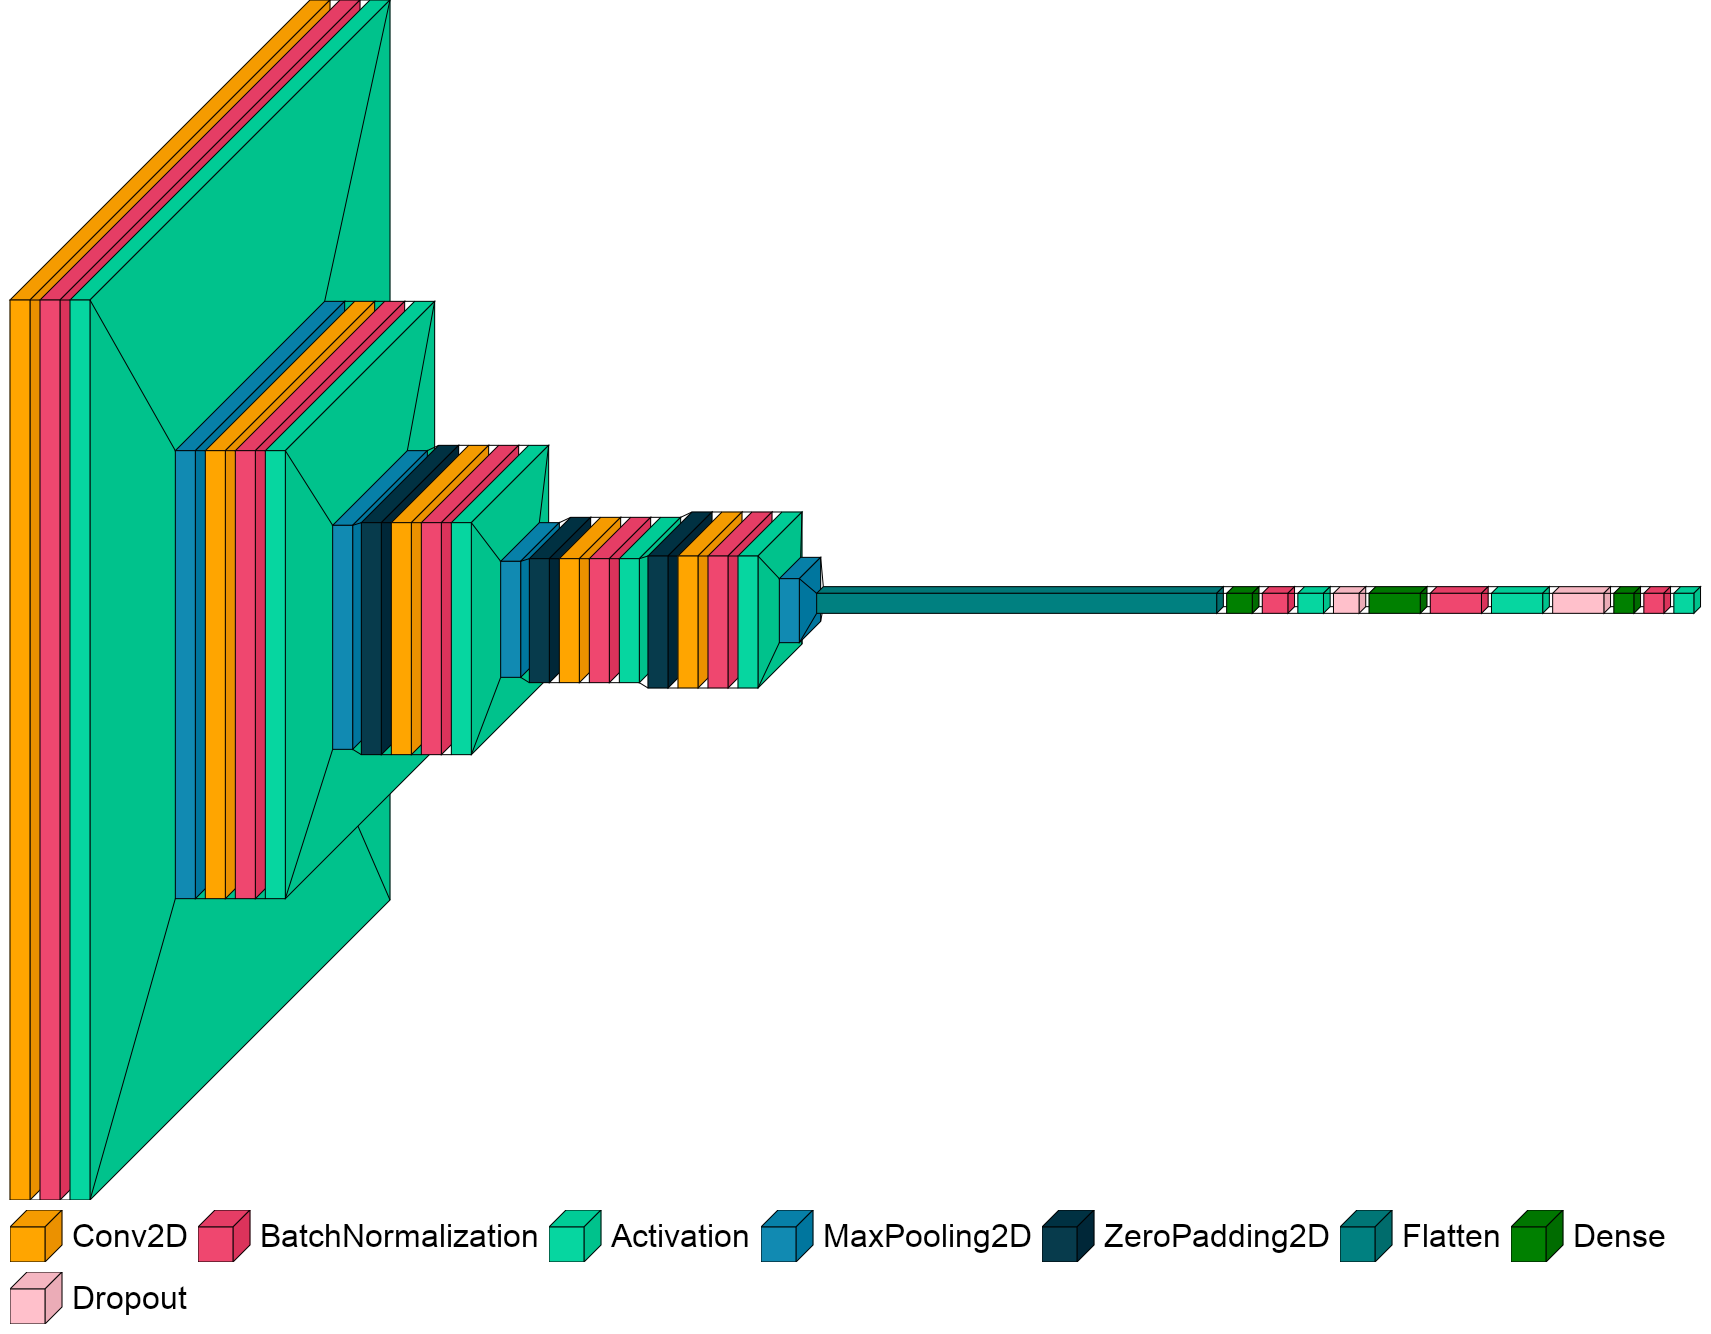

In [58]:
#https://github.com/paulgavrikov/visualkeras/

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Dropout]['fill'] = 'pink'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(modelo, to_file = '/content/drive/MyDrive/Tarea 6/modelo_1v2.png').show()
font = ImageFont.truetype('/content/drive/MyDrive/Tarea 6/arial.ttf', 32)
visualkeras.layered_view(modelo, legend = True, font = font, color_map=color_map)

In [59]:
# ESTE SE HACE EN MI PC
#https://github.com/lutzroeder/Netron
#netron.start('/content/drive/MyDrive/Prácticas/Modelo_Lugares.h5')

In [60]:
# Entrener el modelo
Inicio = time()

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 1e-5)

ksst = modelo.fit(Entrenamiento, epochs = 10, validation_data = Validacion, callbacks = [reduce_lr])

Final = time()
Tiempo_total = Final - Inicio

print("\nTiempo de entrenamiento: {:.0f}h {:.0f}m {:.0f}s.".format(Tiempo_total // (60 * 60),
                                                                   Tiempo_total // 60,
                                                                   Tiempo_total % 60))

Epoch 1/10
1411/1411 [==============================] - 4791s 3s/step - loss: 0.4526 - binary_accuracy: 0.8037 - precision: 0.7778 - recall: 0.7798 - auc: 0.8764 - val_loss: 0.4630 - val_binary_accuracy: 0.7865 - val_precision: 0.8711 - val_recall: 0.6082 - val_auc: 0.8906 - lr: 0.0010
Epoch 2/10
1411/1411 [==============================] - 94s 67ms/step - loss: 0.3946 - binary_accuracy: 0.8344 - precision: 0.8154 - recall: 0.8097 - auc: 0.9031 - val_loss: 0.4289 - val_binary_accuracy: 0.8048 - val_precision: 0.7623 - val_recall: 0.8130 - val_auc: 0.8877 - lr: 0.0010
Epoch 3/10
1411/1411 [==============================] - 94s 66ms/step - loss: 0.3678 - binary_accuracy: 0.8481 - precision: 0.8306 - recall: 0.8257 - auc: 0.9156 - val_loss: 0.3557 - val_binary_accuracy: 0.8557 - val_precision: 0.8035 - val_recall: 0.8927 - val_auc: 0.9294 - lr: 0.0010
Epoch 4/10
1411/1411 [==============================] - 94s 66ms/step - loss: 0.3540 - binary_accuracy: 0.8564 - precision: 0.8406 - recall

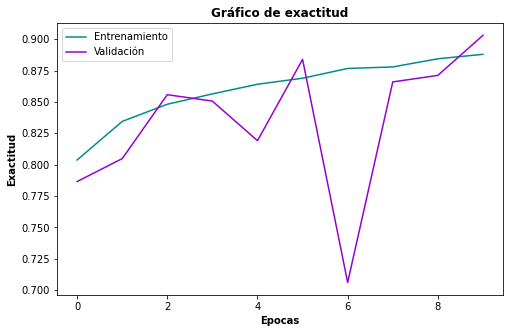

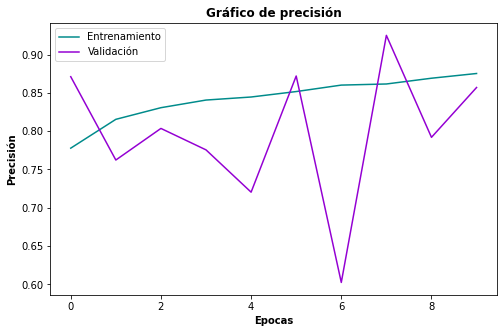

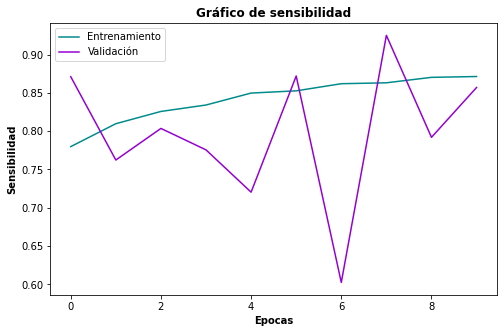

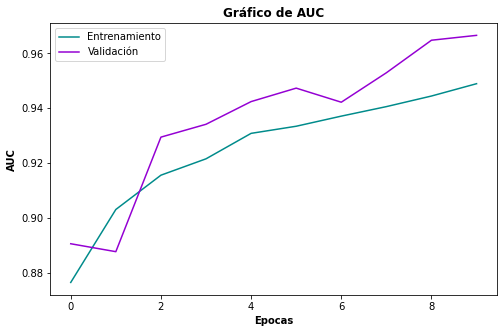

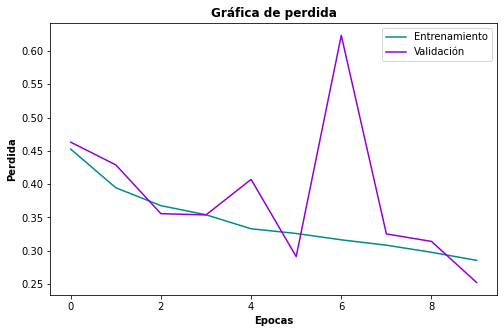

In [79]:
Epocas = range(len(ksst.history['binary_accuracy']))

# Gráfico de accuracy
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['binary_accuracy'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_binary_accuracy'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Exactitud', fontweight = 'bold')
plt.title('Gráfico de exactitud', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de precision
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['precision'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_precision'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Precisión', fontweight = 'bold')
plt.title('Gráfico de precisión', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de recall
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['recall'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_precision'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Sensibilidad', fontweight = 'bold')
plt.title('Gráfico de sensibilidad', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de auc
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['auc'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_auc'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('AUC', fontweight = 'bold')
plt.title('Gráfico de AUC', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfica de loss
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['loss'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_loss'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Perdida', fontweight = 'bold')
plt.title('Gráfica de perdida', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

In [63]:
# Evaluación del modelo
# https://stackoverflow.com/questions/63684459/should-i-use-evaluate-generator-or-evaluate-to-evaluate-my-cnn-model
# Se debe usar .fit y .evaluate, porque .fit_generator y .evaluate_generator estan obsoletos
Evaluacion_modelo = modelo.evaluate(Prueba)
Evaluacion_modelo

158/158 [==============================] - 1158s 7s/step - loss: 0.2225 - binary_accuracy: 0.9172 - precision: 0.9147 - recall: 0.8966 - auc: 0.9664


[0.2225325107574463,
 0.9172304272651672,
 0.9146788716316223,
 0.8965827226638794,
 0.9664044380187988]

In [64]:
print(f"Exactitud del conjunto de prueba: {Evaluacion_modelo[1]*100:.2f}%\n")
print(f"Presición del conjunto de prueba: {Evaluacion_modelo[2]*100:.2f}%\n")
print(f"Sensibilidad del conjunto de prueba: {Evaluacion_modelo[3]*100:.2f}%\n")
print(f"Área bajo la curva del conjunto de prueba: {Evaluacion_modelo[2]*100:.2f}%\n")
print(f"Perdida del conjunto de prueba: {Evaluacion_modelo[0]*100:.2f}%")

Exactitud del conjunto de prueba: 91.72%

Presición del conjunto de prueba: 91.47%

Sensibilidad del conjunto de prueba: 89.66%

Área bajo la curva del conjunto de prueba: 91.47%

Perdida del conjunto de prueba: 22.25%


In [65]:
# Predecir del conjunto del prueba
# Se usa .predict para predecir
Predecir = modelo.predict(Prueba)
Predecir

array([[0.06362052],
       [0.02081098],
       [0.09942343],
       ...,
       [0.95666575],
       [0.9482941 ],
       [0.9509469 ]], dtype=float32)

In [66]:
# Etiquetas del conjunto de prueba
Prueba.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [67]:
# Clasificación de acuerdo al umbral de 0.5
Clasificacion = Predecir > 0.5
Clasificacion

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

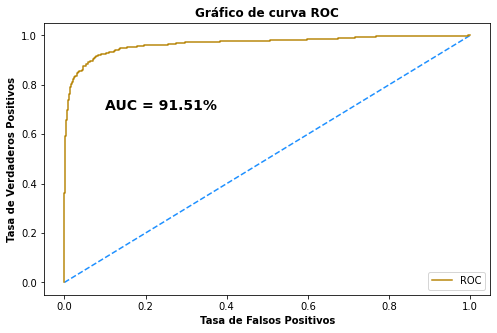

In [82]:
# Gráfico de la curva ROC
ns_probs = [0 for _ in range(len(Prueba.classes))]

ns_fpr, ns_tpr, _ = roc_curve(Prueba.classes, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Prueba.classes, Predecir)
plt.figure(figsize = (8, 5))
plt.plot(ns_fpr, ns_tpr, linestyle='--', color = 'dodgerblue')
plt.plot(lr_fpr, lr_tpr, label = 'ROC', color = 'darkgoldenrod')
plt.xlabel('Tasa de Falsos Positivos', fontweight = 'bold')
plt.ylabel('Tasa de Verdaderos Positivos', fontweight = 'bold')
plt.text(0.1, 0.7, f'AUC = {roc_auc_score(Prueba.classes, Clasificacion)*100:.2f}%', fontsize = 14, fontweight = 'bold')
plt.title('Gráfico de curva ROC', fontweight = 'bold')
plt.legend(loc = 4)
plt.show()

In [69]:
# Reporte de clasificación
Etiquetas_imagenes = ['Orgánico', 'Reciclable']

print('Reporte de clasificación:')
print(classification_report(y_true = Prueba.classes, y_pred = Clasificacion,
                            target_names = Etiquetas_imagenes))

Reporte de clasificación:
              precision    recall  f1-score   support

    Orgánico       0.92      0.93      0.93      1401
  Reciclable       0.91      0.90      0.91      1112

    accuracy                           0.92      2513
   macro avg       0.92      0.92      0.92      2513
weighted avg       0.92      0.92      0.92      2513



Índices: {'O': 0, 'R': 1} 

Matriz de confusión:
[[1308   93]
 [ 115  997]] 



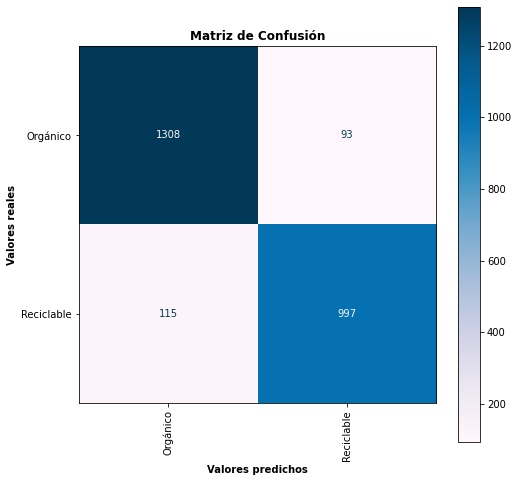



Exactitud: 91.72%

Presición: 91.47%

Sensibilidad: 89.66%

Puntaje F1: 90.55%

Área bajo la curva: 91.51%



In [84]:
# Construcción de matriz de confusión y reporte de clasificación
print("Índices:", Entrenamiento.class_indices, "\n")

matriz = confusion_matrix(y_true = Prueba.classes, y_pred = Clasificacion)

print("Matriz de confusión:")
print(matriz, "\n")

disp = ConfusionMatrixDisplay(confusion_matrix = matriz,
                              display_labels = Etiquetas_imagenes)
fig, ax = plt.subplots(figsize = (8, 8))
disp = disp.plot(xticks_rotation = "vertical", ax = ax, cmap = "PuBu")
plt.title("Matriz de Confusión", fontweight = "bold")
plt.xlabel("Valores predichos", fontweight = "bold")
plt.ylabel("Valores reales", fontweight = "bold")
plt.show()
f1_score
print("\n")
print(f"Exactitud: {accuracy_score(Prueba.classes, Clasificacion)*100:.2f}%\n")
print(f"Presición: {precision_score(Prueba.classes, Clasificacion)*100:.2f}%\n")
print(f"Sensibilidad: {recall_score(Prueba.classes, Clasificacion)*100:.2f}%\n")
print(f"Puntaje F1: {f1_score(Prueba.classes, Clasificacion)*100:.2f}%\n")
print(f"Área bajo la curva: {roc_auc_score(Prueba.classes, Clasificacion)*100:.2f}%\n")

In [72]:
# ANTES DE CORRER ESTA LINEA, ASEGURESE DE NO TENER EL MODELO GUARDADO ANTERIORMENTE

# Guardar el modelo
modelo.save('/content/drive/MyDrive/Tarea 6/Modelo_Residuos.h5')

# Guardar los pesos del modelo
modelo.save_weights('/content/drive/MyDrive/Tarea 6/Modelo_Pesos_Residuos.h5')